In [18]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1234)

In [5]:
W = np.array(
    [[0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
     [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0],
     [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1],
     [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
     [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0],
     [1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
     [1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
     [0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0],
     [0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
     [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
     [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
     [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0],
     [1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
     [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
     [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
     [1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]]
)

n_nodes = W.shape[0]

In [3]:
worm_path = "./worm.npy"

W = np.load(worm_path)
n_nodes = W.shape[0]

In [4]:
def get_number_of_edges(W: np.ndarray):
    return np.sum(W)

def get_number_of_reciprocal_edges(W: np.ndarray):
    return (W * W.T).sum() / 2

def calculate_graph_statistics(W: np.ndarray, feature_calculators):
    """
    Given a directed graph W and a list of callable feature calculators, we calculate the graph statistics.

    Parameters:
        W: Connectivity matrix for which the statistics should be calculated
        feature_calculators: a list of callable feature calculators. Each feature calculator should be a callable object that receives a connectivity matrix, and returns the feature statistics.

    Returns:
        A numpy array containing the graph statistics.
    """
    num_features = len(feature_calculators)
    statistics = np.zeros(num_features)

    for i, feature_calculator in enumerate(feature_calculators):
        statistics[i] = feature_calculator(W)

    return statistics

def MCMC_graph_sample(thetas: np.ndarray,
                      feature_calculators,
                      n_nodes: int,
                      num_graphs=1000,
                      seed_graph=None,
                      seed_graph_edge_probability=0.1,
                      burn_in=1000,
                      steps_per_sample=10
                      ):
    """
    Run an MCMC sampling process sample graphs from the current distribution.

    Parameters:
        thetas: current  distribution parameters, of size `# of features`.
        feature_calculators: a list of callable feature calculators.
        n_nodes: number of nodes in the graph.
        num_graphs: number of graphs to sample.
        seed_graph_edge_probability: Edge probability of the seed graph, generated from an Erdős–Rényi model.
        burn_in: number of graphs that aren't collected to the final sample, as part of the burn in process.
        steps_per_sample: number of edge flips before evaluating a candidate graph.

    Returns:
        A list of `num_graphs`, sampled from the distribution.
    """
    if seed_graph is None:
        seed_graph = np.random.choice([0, 1], size=(n_nodes, n_nodes), p=[1-seed_graph_edge_probability, seed_graph_edge_probability])
        seed_graph[np.diag_indices(n_nodes)] = 0

    sampled_graphs = []

    current_graph = seed_graph
    current_statistics = calculate_graph_statistics(current_graph, feature_calculators)

    mcmc_iter_count = 0

    num_accepted = 0
    num_rejected = 0
    while len(sampled_graphs) < num_graphs:
        proposed_graph = current_graph.copy()

        for k in range(steps_per_sample):
            i, j = np.random.choice(n_nodes, 2, replace=False)

            proposed_graph[i, j] = 1 - proposed_graph[i, j]

        proposed_statistics = calculate_graph_statistics(proposed_graph, feature_calculators)

        change_score = proposed_statistics - current_statistics
        acceptance_proba = min(1, np.exp(thetas @ change_score))

        if np.random.random() < acceptance_proba:
            num_accepted += 1
            current_graph = proposed_graph
            current_statistics = proposed_statistics
            if mcmc_iter_count > burn_in:
                sampled_graphs.append(current_graph.copy())
        else:
            num_rejected += 1

        mcmc_iter_count += 1

    print(f"Number of accepted graphs: {num_accepted}, number of rejected graphs: {num_rejected}")
    return sampled_graphs

def calculate_mean_statistics(sample_graphs: list, feature_calculators):
    """
    Calculate the mean statistics over a collection of graphs.

    Parameters:
        sample_graphs: a list of graphs, each graph is a numpy array.
        feature_calculators: a list of callable feature calculators.

    Returns:
        The mean statistics over the provided graphs, of size `# of features`.
    """
    statistics = np.zeros((len(sample_graphs), len(feature_calculators)))

    for i, W in enumerate(sample_graphs):
        statistics[i] = calculate_graph_statistics(W, feature_calculators)

    return np.mean(statistics, axis=0)


In [12]:
feature_calculators = [get_number_of_edges, get_number_of_reciprocal_edges]
observed_stats = calculate_graph_statistics(W, feature_calculators)
print(f"Number of edges - {observed_stats[0]}")
print(f"Number of reciprocal edges - {observed_stats[1]}")

Number of edges - 88.0
Number of reciprocal edges - 28.0


In [21]:
# feature_calculators = [get_number_of_edges, get_number_of_reciprocal_edges]
feature_calculators = [get_number_of_edges]
observed_stats = calculate_graph_statistics(W, feature_calculators)
num_features = len(observed_stats)

initial_thetas = np.random.uniform(-1, 1, num_features)
num_opt_steps = 100
learning_rate = 0.001
MCMC_number_of_graphs_per_sample = 100
MCMC_burn_in = 0
MCMC_seed_graph_density = np.sum(W) / (n_nodes * (n_nodes-1))

seed_graph = np.random.choice([0, 1], size=(n_nodes, n_nodes), p=[1-MCMC_seed_graph_density, MCMC_seed_graph_density])
seed_graph[np.diag_indices(n_nodes)] = 0

print(f"Observed statistics - {observed_stats}")
print(f"Seed MCMC graph density - {MCMC_seed_graph_density}")
print(f"Initial thetas: {initial_thetas}")
gradients = []
thetas = initial_thetas

all_graphs = []
all_thetas = []
for i in range(num_opt_steps):
    all_thetas.append(thetas)
    print(f"Working on step {i+1}/{num_opt_steps}")

    if i == 0:
        burn_in = MCMC_burn_in
    else:
        burn_in = 0

    sample_graphs = MCMC_graph_sample(
        thetas=thetas,
        feature_calculators=feature_calculators,
        n_nodes=n_nodes,
        num_graphs=MCMC_number_of_graphs_per_sample,
        seed_graph=seed_graph,
        burn_in=burn_in,
        steps_per_sample=5
    )

    print(f"\tSampled {len(sample_graphs)} graphs")

    sample_statistics = calculate_mean_statistics(sample_graphs, feature_calculators)
    print(f"\tMean statistics: {sample_statistics}")
    gradient = sample_statistics - observed_stats
    gradients.append(gradient)
    print(f"\tGradient: {gradient}")

    thetas = thetas - learning_rate * gradient

    # Use the last sampled graph for the next starting point of the MCMC chain
    seed_graph = sample_graphs[-1]

    all_graphs.extend(sample_graphs)

Observed statistics - [88.]
Seed MCMC graph density - 0.2875816993464052
Initial thetas: [0.56417876]
Working on step 1/100
Number of accepted graphs: 101, number of rejected graphs: 40
	Sampled 100 graphs
	Mean statistics: [151.84]
	Gradient: [63.84]
Working on step 2/100
Number of accepted graphs: 101, number of rejected graphs: 73
	Sampled 100 graphs
	Mean statistics: [185.8]
	Gradient: [97.8]
Working on step 3/100
Number of accepted graphs: 100, number of rejected graphs: 68
	Sampled 100 graphs
	Mean statistics: [188.04]
	Gradient: [100.04]
Working on step 4/100
Number of accepted graphs: 101, number of rejected graphs: 45
	Sampled 100 graphs
	Mean statistics: [178.14]
	Gradient: [90.14]
Working on step 5/100
Number of accepted graphs: 101, number of rejected graphs: 30
	Sampled 100 graphs
	Mean statistics: [177.38]
	Gradient: [89.38]
Working on step 6/100
Number of accepted graphs: 101, number of rejected graphs: 19
	Sampled 100 graphs
	Mean statistics: [169.74]
	Gradient: [81.74]

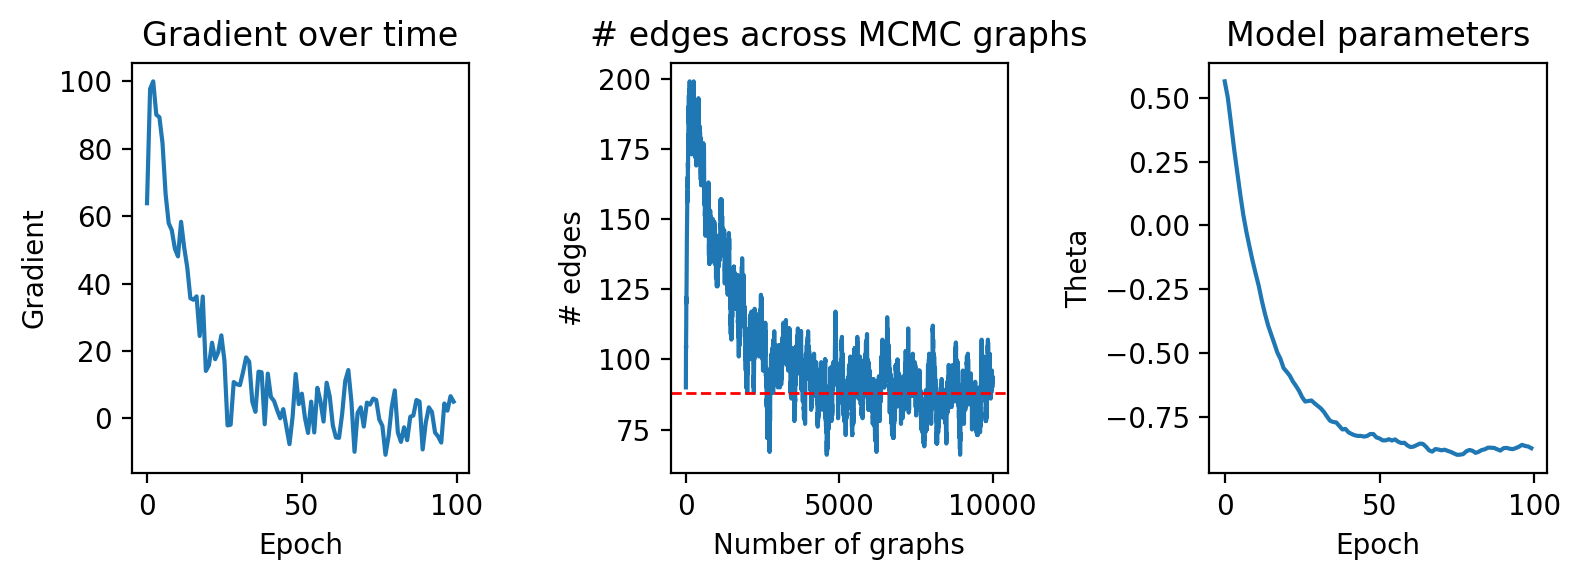

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 3), dpi=200)
# fig, ax = plt.subplots(nrows=1, ncols=3)

ax[0].plot(np.mean(gradients, axis=1))
ax[0].set_title("Gradient over time")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Gradient")

ax[1].plot([np.sum(g) for g in all_graphs])
ax[1].set_title("# edges across MCMC graphs")
ax[1].set_xlabel("Number of graphs")
ax[1].axhline(y=88, color='red', linestyle='--', linewidth=1)
ax[1].set_ylabel("# edges")

ax[2].plot(all_thetas)
ax[2].set_title("Model parameters")
# ax[2].axhline(y=-0.9, color='red', linestyle='--', linewidth=1)
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Theta")

plt.tight_layout()
plt.show()